C:\Users\bsksh\AppData\Local\Temp\ipykernel_12972\3601031199.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(labels, rotation=45, ha='right')
C:\Users\bsksh\AppData\Local\Temp\ipykernel_12972\3601031199.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(labels, rotation=45, ha='right')
C:\Users\bsksh\AppData\Local\Temp\ipykernel_12972\3601031199.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(labels, rotation=45, ha='right')
C:\Users\bsksh\AppData\Local\Temp\ipykernel_12972\3601031199.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(labels, rotation=

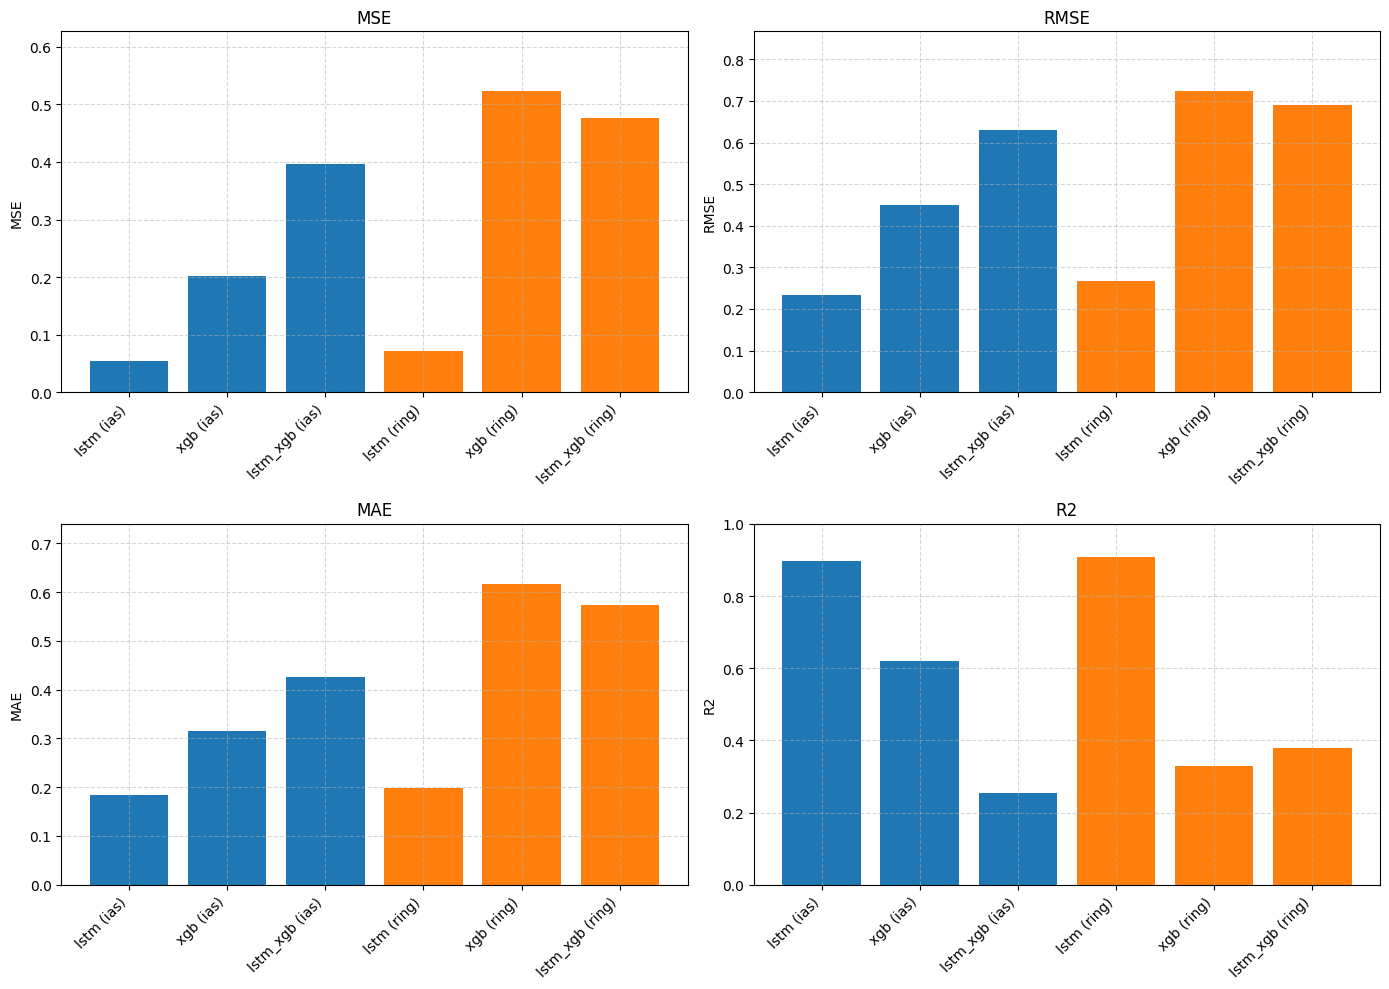

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 比較モデル
files = [
    "ias_lstm.csv",
    "ias_xgb.csv",
    "ias_lstm_xgb.csv",
    "ring_lstm.csv",
    "ring_xgb.csv",
    "ring_lstm_xgb.csv"
]

# resultsフォルダのパス
results_dir = "../results"

# 読み込みと整理用リスト
data = []

for f in files:
    filepath = os.path.join(results_dir, f)
    df = pd.read_csv(filepath)
    # ファイル名からセンサ名とモデル名を抽出（例：ias_xgb.csv -> ias, xgb）
    base = os.path.splitext(f)[0]
    sensor, model = base.split("_", 1)
    # それぞれの指標を辞書にして追加
    entry = {
        "Sensor": sensor,
        "Model": model,
        "MSE": df.loc[0, "MSE"],
        "RMSE": df.loc[0, "RMSE"],
        "MAE": df.loc[0, "MAE"],
        "R2": df.loc[0, "R2"]
    }
    data.append(entry)

# DataFrame化
df_results = pd.DataFrame(data)

# 指標ごとにグラフ描画
metrics = ["MSE", "RMSE", "MAE", "R2"]

# 横軸のラベルとしてモデル名+センサ名を作る
labels = df_results["Model"] + " (" + df_results["Sensor"] + ")"

fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    axs[i].bar(labels, df_results[metric], color=['#1f77b4' if 'ias' in s else '#ff7f0e' for s in df_results['Sensor']])
    axs[i].set_title(metric)
    axs[i].set_ylabel(metric)
    axs[i].set_xticklabels(labels, rotation=45, ha='right')
    if metric == "R2":
        axs[i].set_ylim(0, 1)
    else:
        axs[i].set_ylim(0, max(df_results[metric])*1.2)
    axs[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
